[ 14  13  44  41  22 162  42 169 108 153  19  92   8   7 165 167  40  29
 147  30 152 151 117 124   4  17   6  18 149 148 109  77 101  39 127 128
  52 154 160 155  20   5  46 168  15  37  26 137  62  45  85 146 106  76
  72 104 163  21  48 129 133 132 107  61 118  65  70  71  38  98  89  78
  96 145 143  32  31 150  93  91  90   9 139  24  23 161 159 158  87  86
  84  83  82  81  80  79  75  74 105 103 102 100  99  73  69  68  67  66
 113 112 111 110  64  60  59  58  57  56  55  54  53  51  50 121 120 119
 116 115 114  49  43 126 125 122  36  35  34 135 134 130  33  28  27 144
 141 140 157 156  16  12  11  10 164   3   2  97  95  94  88 166   1   0
 142 136 131  47 123  63 138  25]
[18. 18. 16. 16. 16. 14. 14. 14. 14. 14. 14. 12. 12. 12. 12. 12. 12. 12.
 12. 12. 12. 12. 12. 12. 12. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.  8.
  8.  8.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.  6.
  6.  6.  6.  6. 

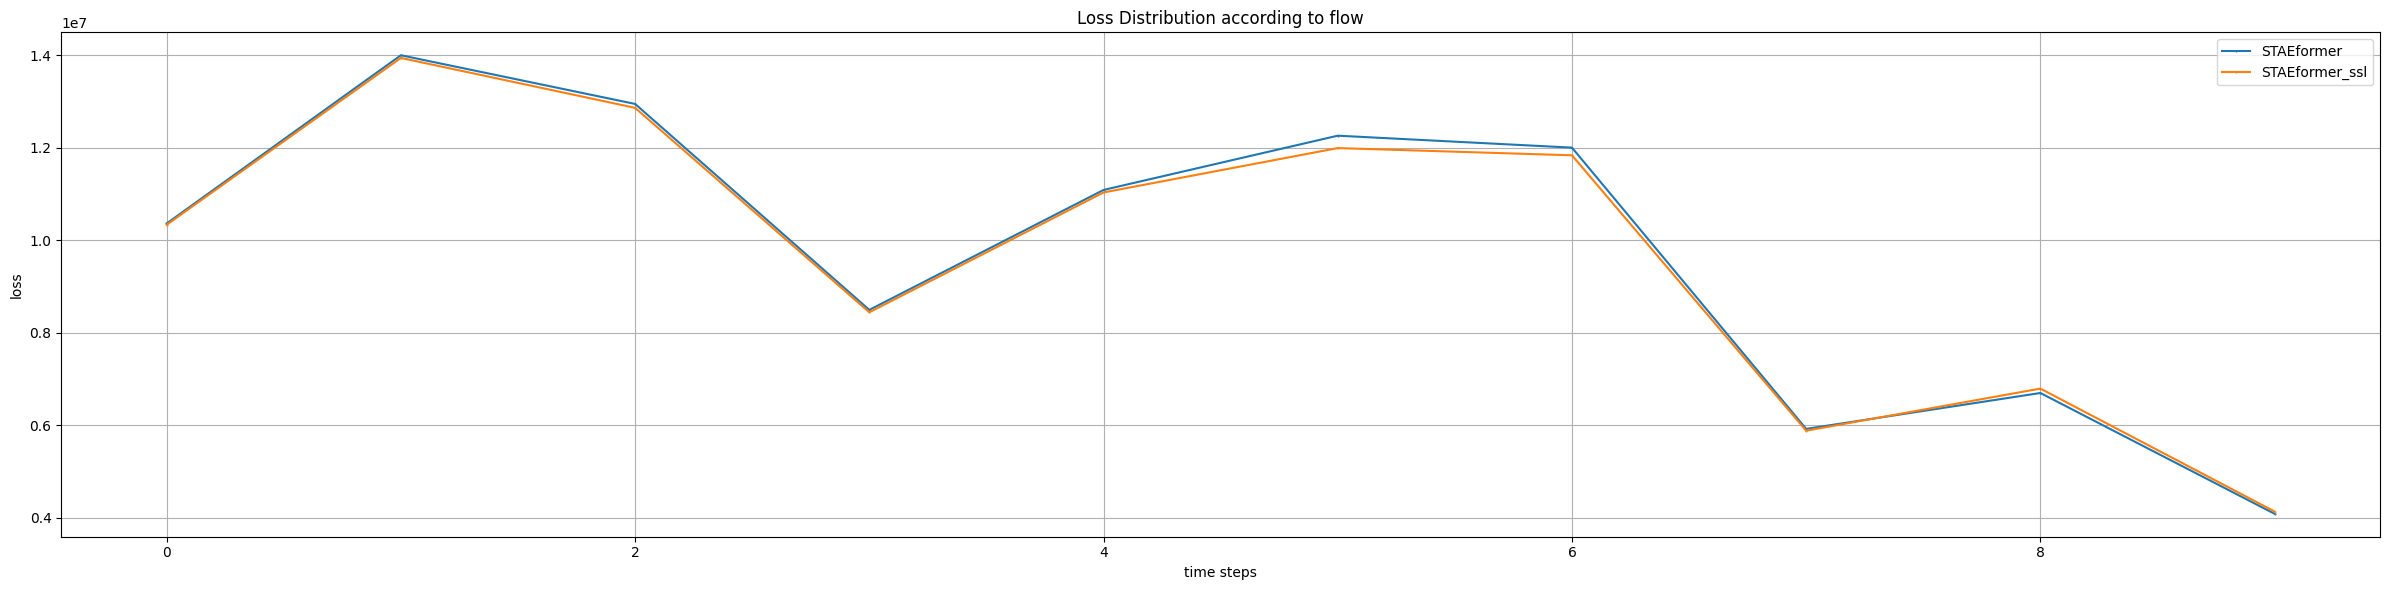

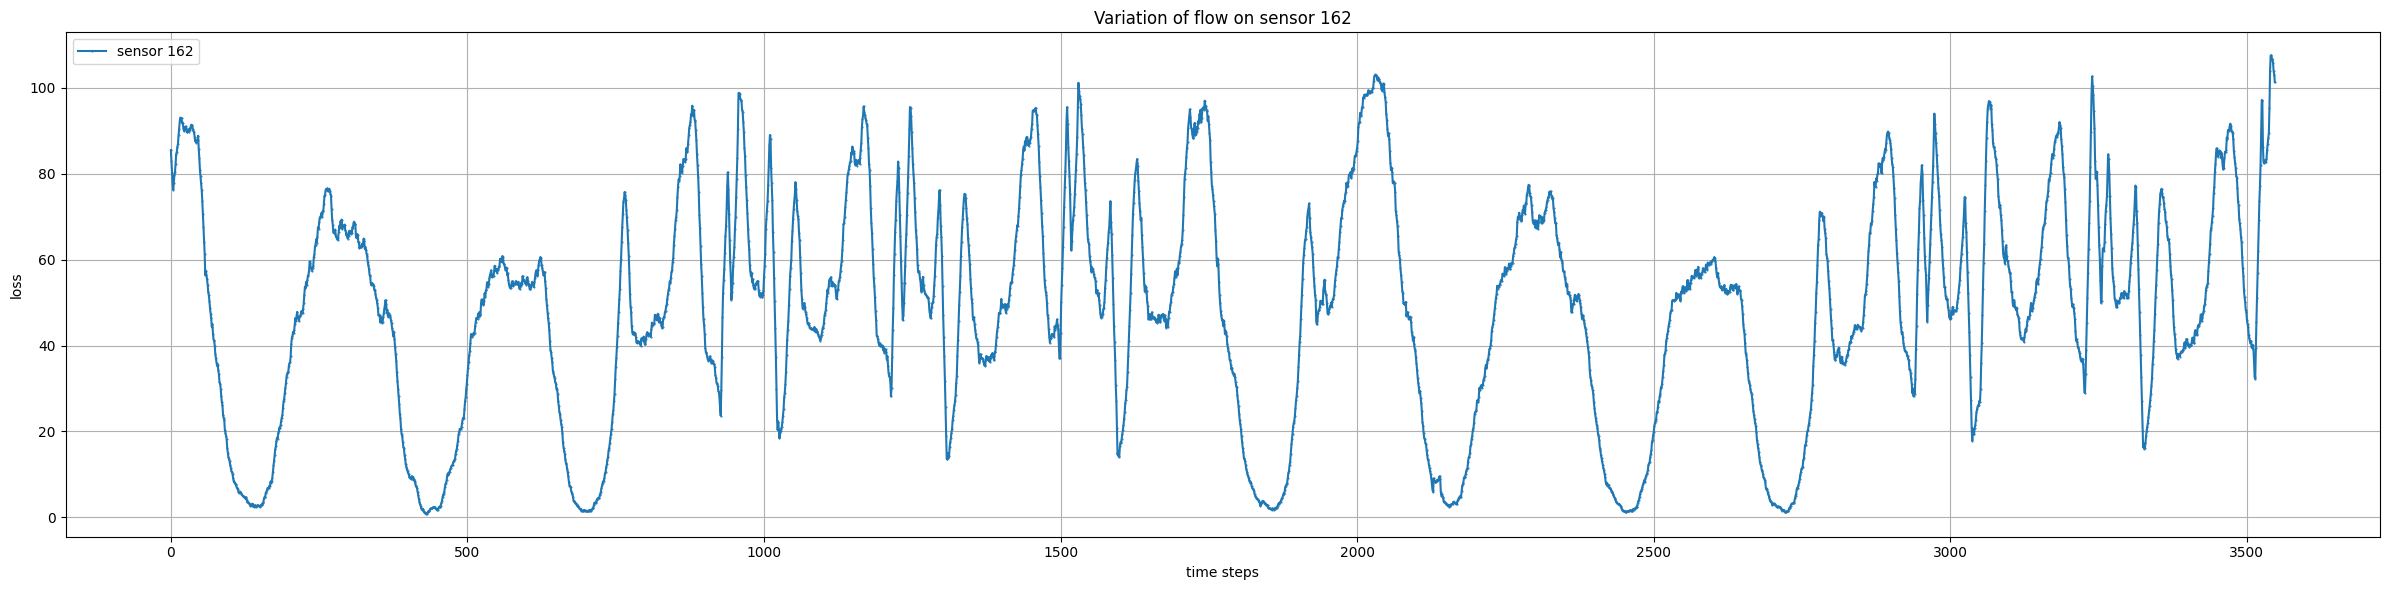

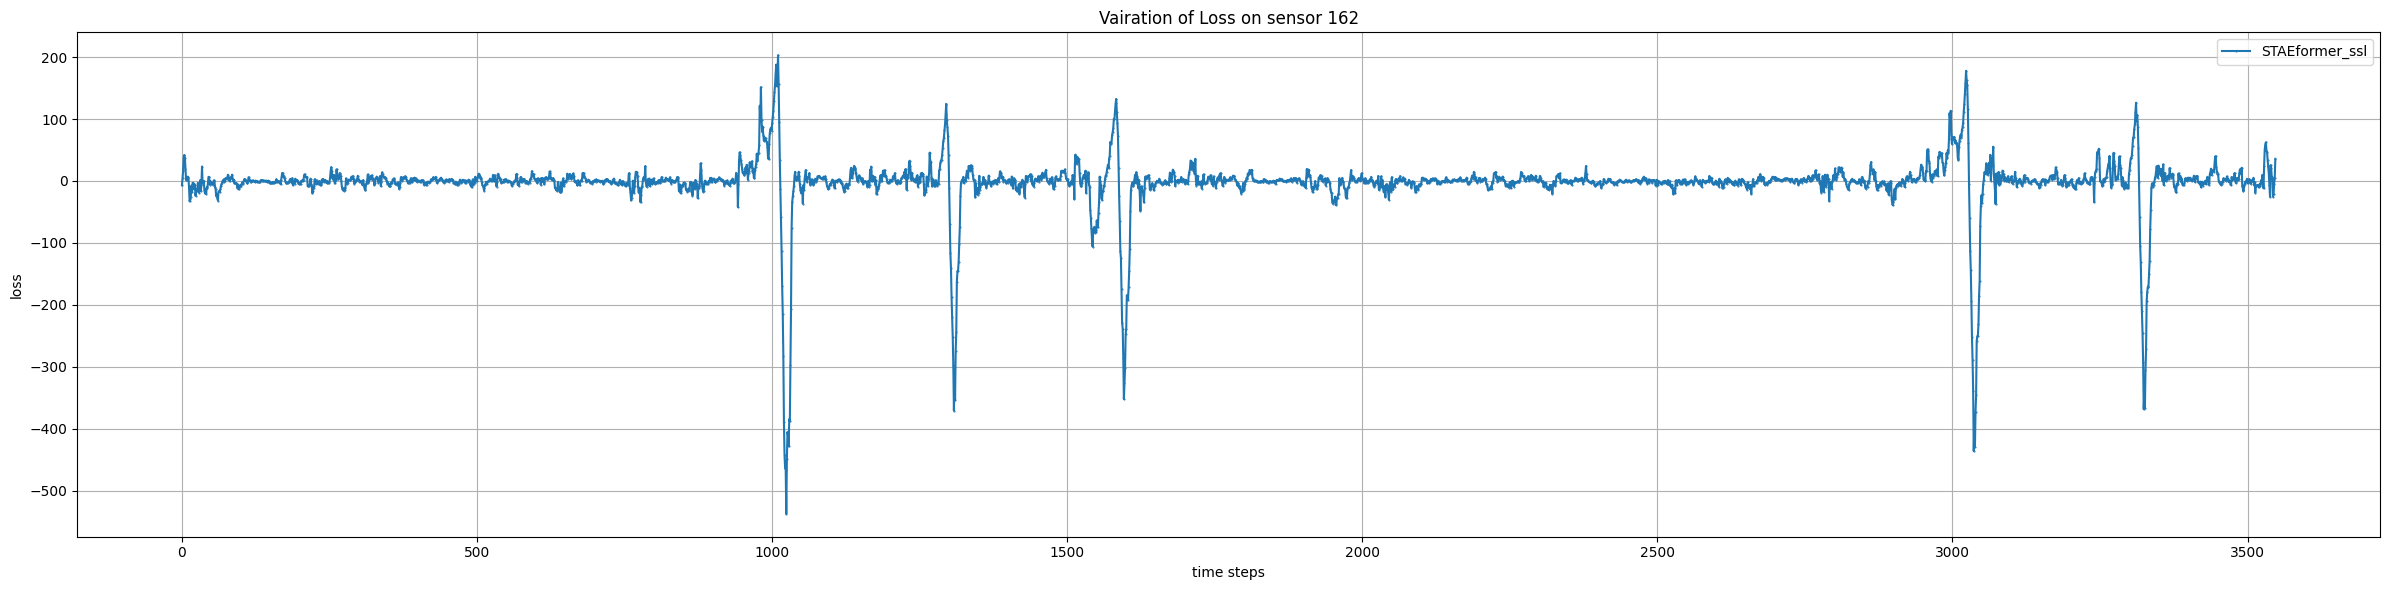

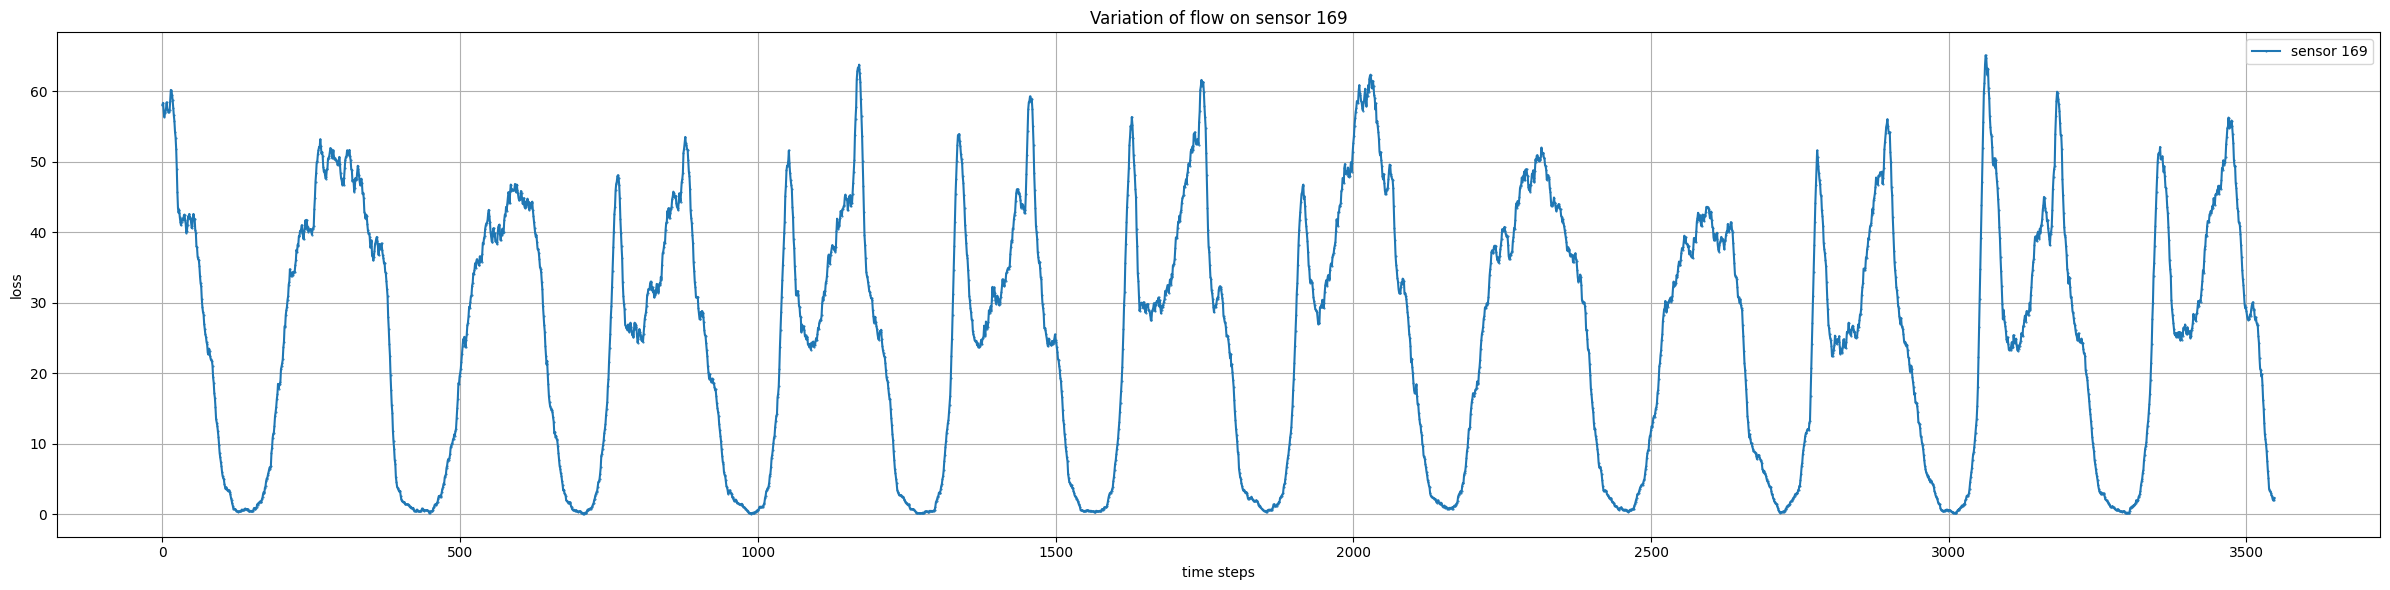

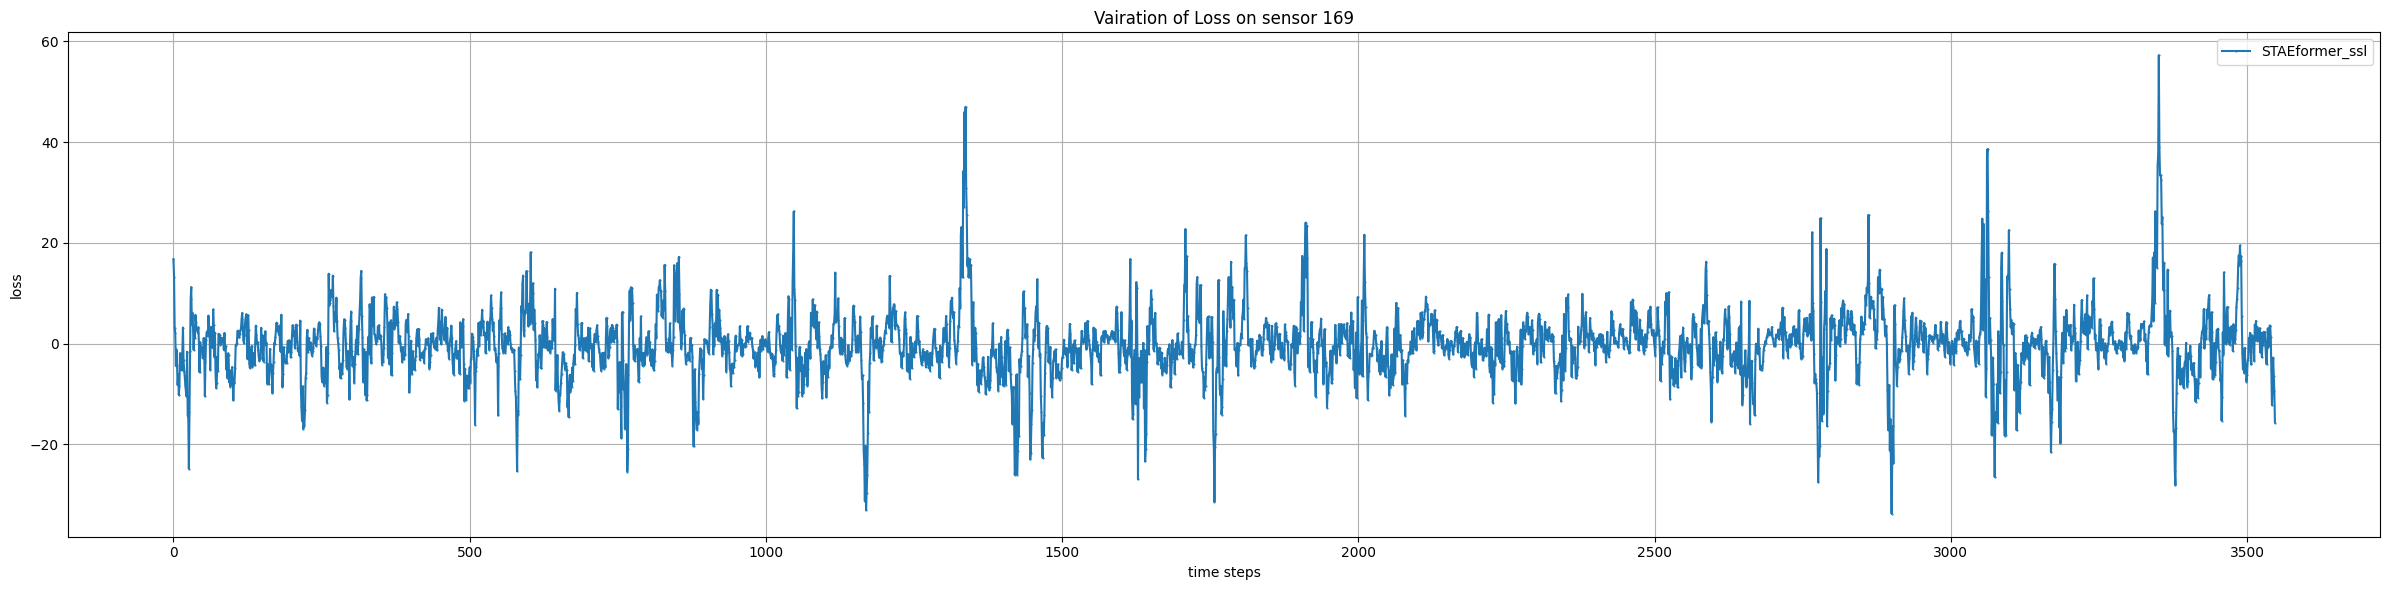

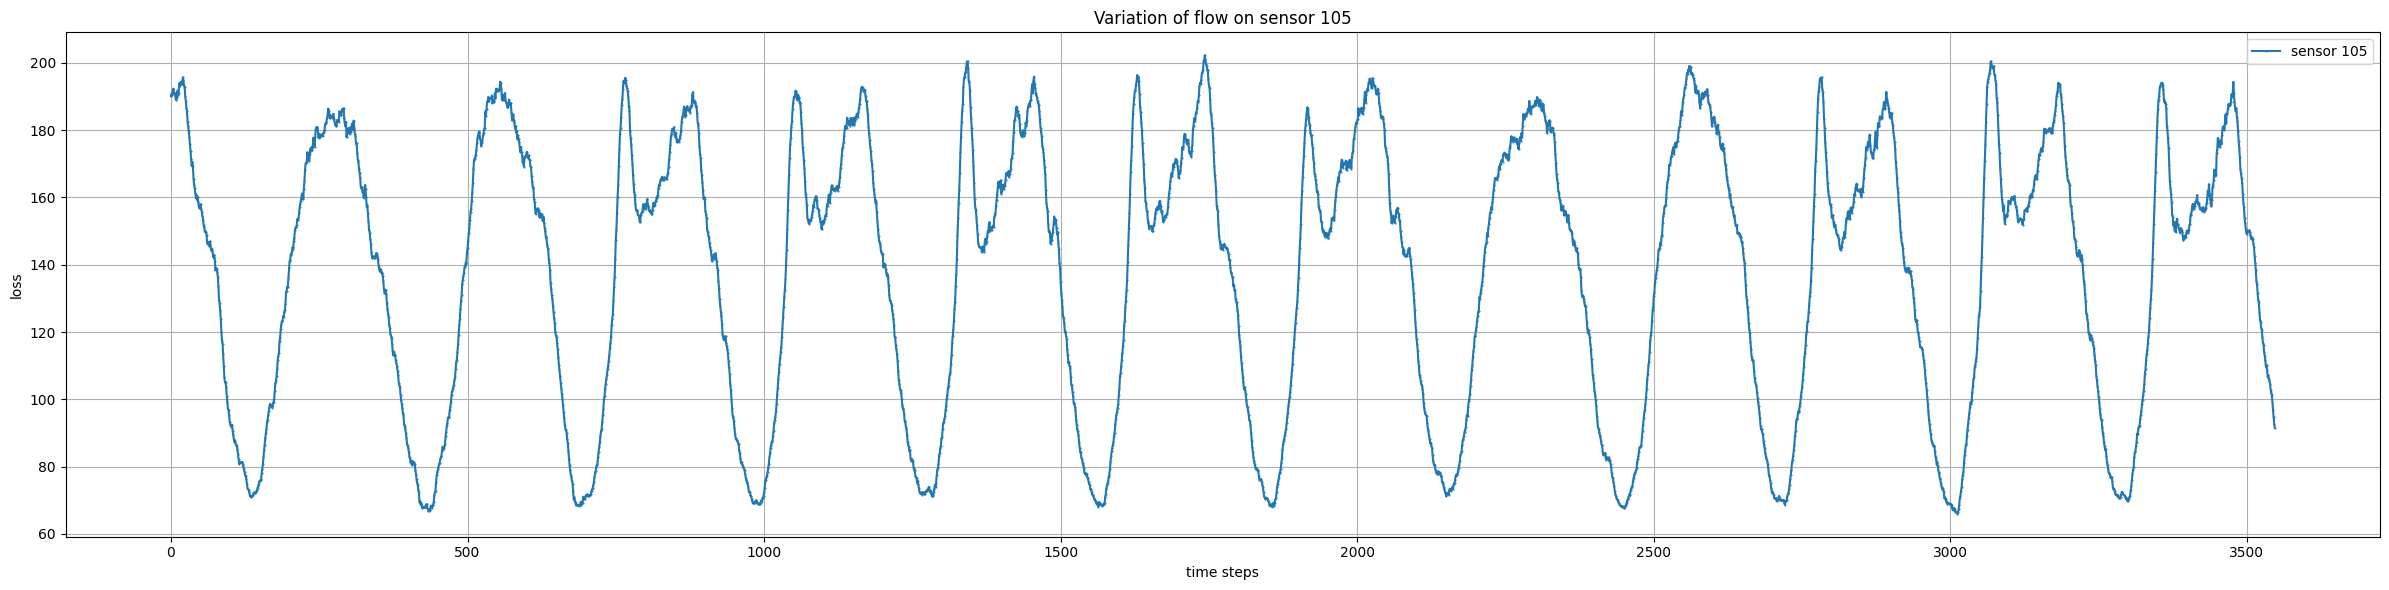

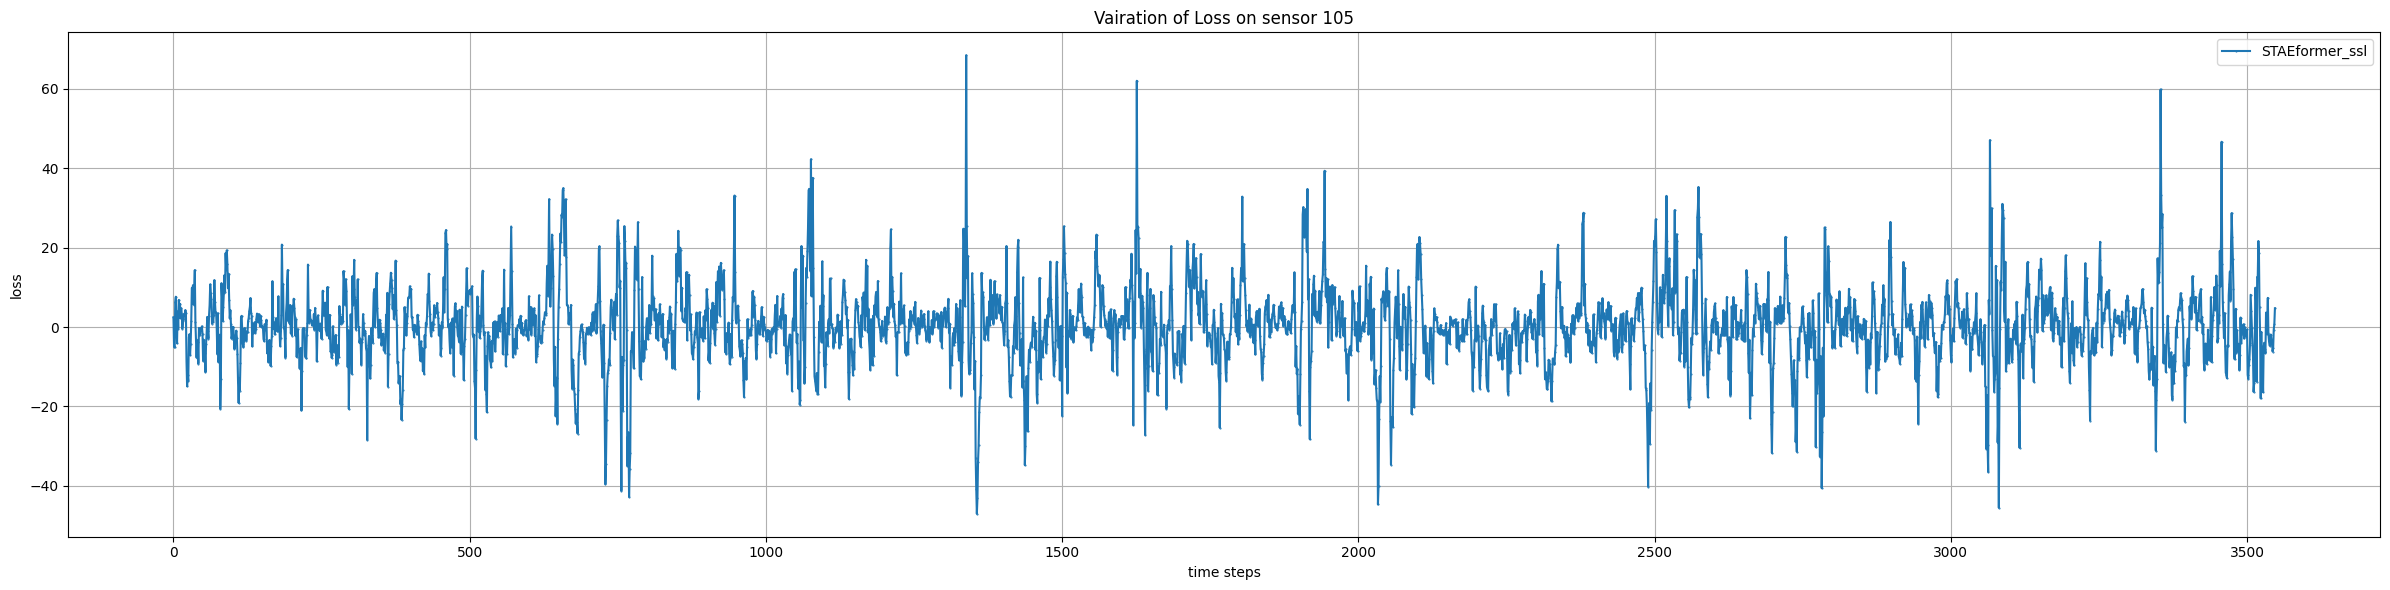

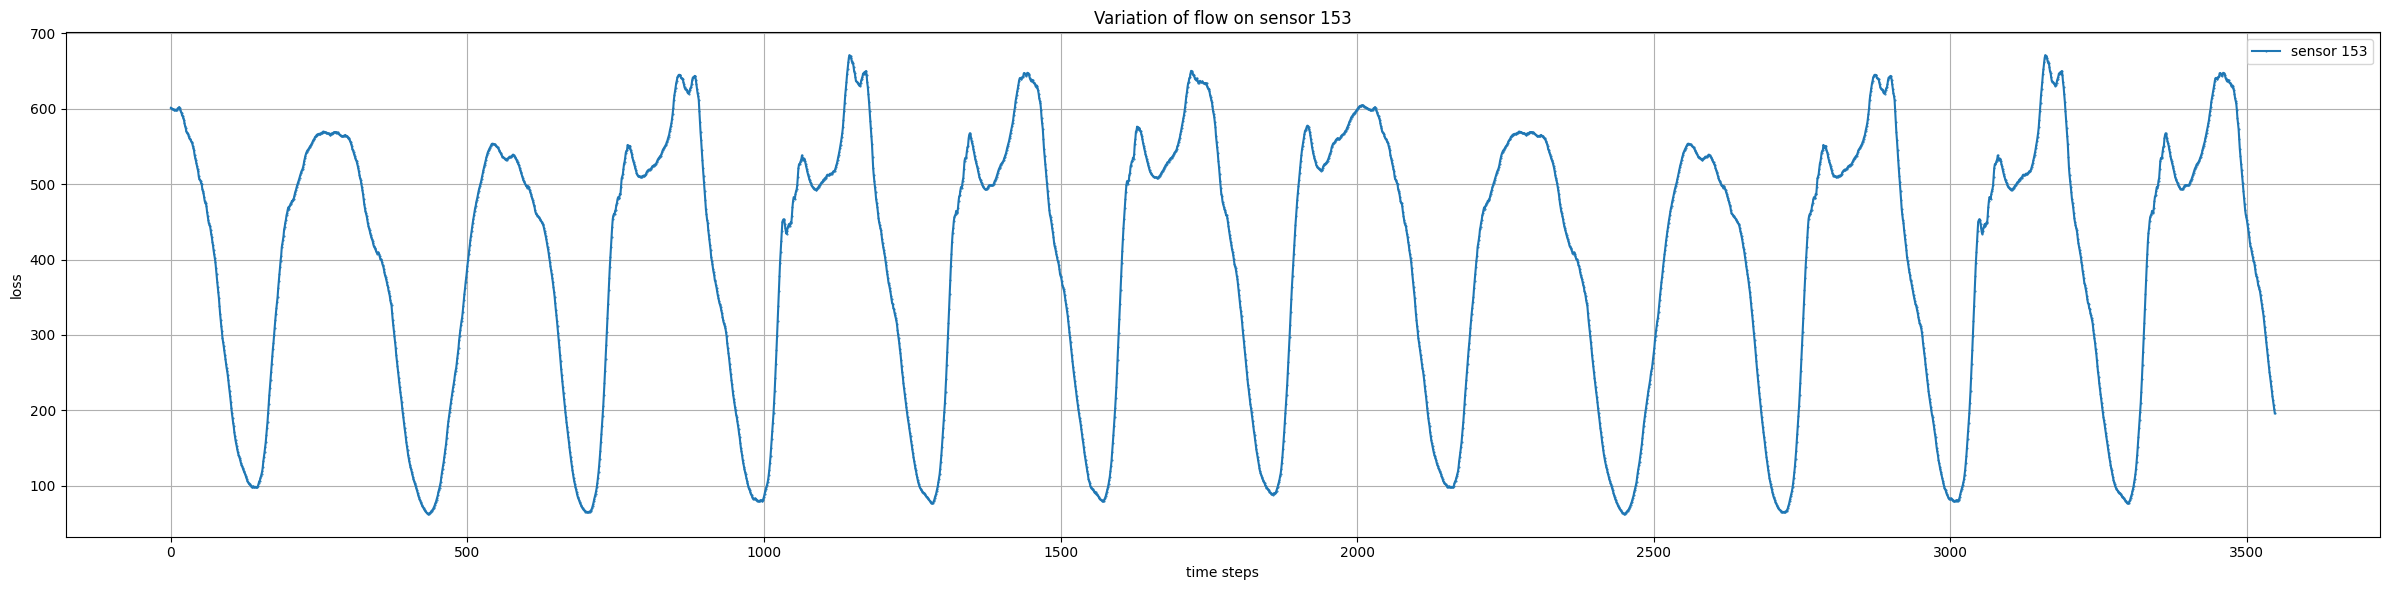

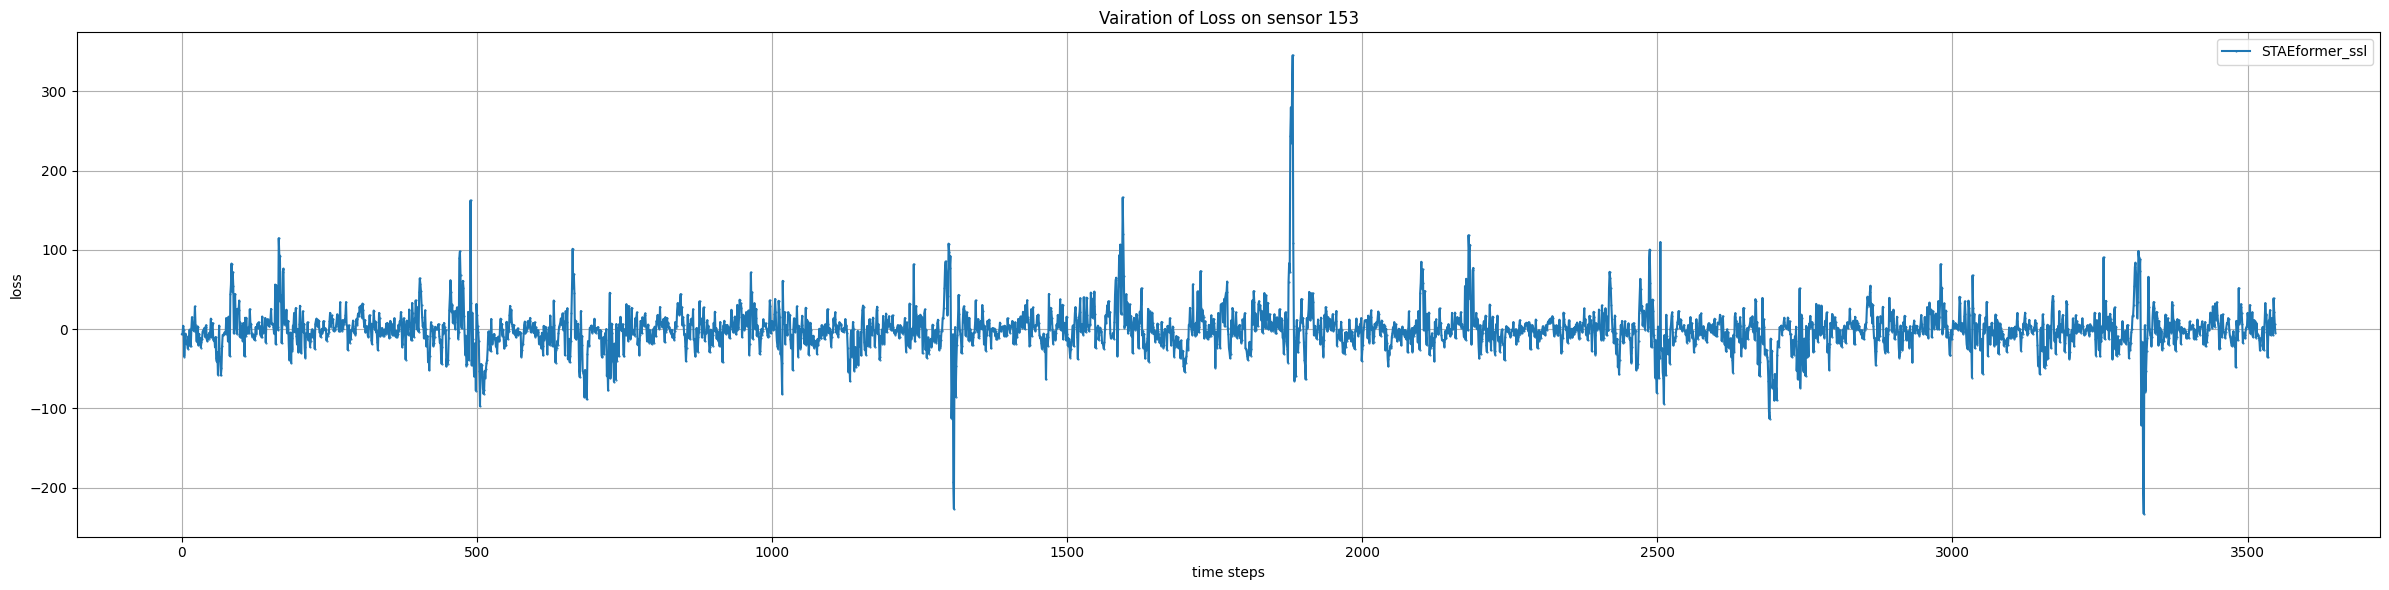

In [26]:
import numpy as np

from basicts.utils.result import stat_node, read_result_file
from basicts.utils.visualize import plot_line

# 这个文件的意义是对loss的分布进行统计
# 数据集的名称
dataset_path = "/data3/hanzhi/BasicTS/datasets/PEMS08"
dataset_shape = (17856, 170, 3)
# 预测值的位置
prediction_paths = [
    "/data3/hanzhi/BasicTS/checkpoints/STAEformer/PEMS08_100_12_12/70ceb2d1dd84b5dc181774f2d16a14c1/test_results.npz",
    #"/data3/hanzhi/BasicTS/checkpoints/STAEformer/PEMS08_100_12_12/5154b76a28d37361e94e849708bf6584/test_results.npz",
    "/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/PEMS08_100_12_12/ec5b5664aa4430d0d0c4f91673ef85c6/test_results.npz",
    #"/data3/hanzhi/BasicTS/checkpoints/STAEformer_SSL/PEMS08_100_12_12/a4c78e002fd407ebeb86435d91606391/test_results.npz",
]
# 名称
prediction_names = [
    "STAEformer",
    #"STAEformer_fs",
    "STAEformer_ssl",
    #"STAEformer_fs_ssl"
]

def visualize_loss_by_connection(dataset_path: str, prediction_paths: list, prediction_names: list):
    """
    按照连接的边的数量和车流量进行loss的分组展示
    """
    # note 先对数据集的节点性质做统计
    index_degree, degree, index_flow, flow = stat_node(dataset_path, dataset_shape)
    # 连接边的数目到节点的映射
    degree2nodes = dict()
    for i, d in zip(index_degree.tolist(), degree.tolist()):
        if d not in degree2nodes:
            degree2nodes[d] = []
        degree2nodes[d].append(i)
    degrees = list(degree2nodes.keys())
    degrees.sort()
    print(degree2nodes)
    print(degrees)
    # note 再对数据集的预测结果做统计
    # 若干个列表，每个列表横轴是id，值是这个节点的mae
    node2maes = []
    for pred in prediction_paths:
        # (I, T, N, C)
        inputs, targets, predictions = read_result_file(pred)
        # (I, T, N, C) -> (N, I, T)
        targets = targets[:, :, :, 0].transpose(2, 0, 1)
        predictions = predictions[:, :, :, 0].transpose(2, 0, 1)
        loss = np.abs(targets - predictions)
        # (N, I, T) -> (N)
        loss = np.sum(loss, axis=-1)
        loss = np.sum(loss, axis=-1)
        node2maes.append([])
        for d in degrees:
            node2maes[-1].append(np.mean(loss[np.array(degree2nodes[d])]))
            if d == 14:
                print(degree2nodes[d], loss[np.array(degree2nodes[d])])
    print(node2maes)
    plot_line(title="Loss Distribution according to connections", x=degrees,
              ys=node2maes, y_names=prediction_names)

def visualize_loss_by_flow(dataset_path: str, prediction_paths: list, prediction_names: list):
    """
    按照连接的边的数量和车流量进行loss的分组展示
    """
    # note 先对数据集的节点性质做统计
    index_degree, degree, index_flow, flow = stat_node(dataset_path, dataset_shape)
    count_nodes = index_flow.shape[0]
    # 统计一下排名
    flow2maes = []
    for pred in prediction_paths:
                # (I, T, N, C)
        inputs, targets, predictions = read_result_file(pred)
        # (I, T, N, C) -> (N, I, T)
        targets = targets[:, :, :, 0].transpose(2, 0, 1)
        predictions = predictions[:, :, :, 0].transpose(2, 0, 1)
        loss = np.abs(targets - predictions)
        # (N, I, T) -> (N)
        loss = np.sum(loss, axis=-1)
        loss = np.sum(loss, axis=-1)
        flow2maes.append([])
        bin = count_nodes // 10
        for i in range(10):
            if bin*(i+1) <= count_nodes:
                flow2maes[-1].append(np.sum(loss[index_flow[bin*i:bin*(i+1)]]))
            else:
                flow2maes[-1].append(np.sum(loss[index_flow[bin*i:]]))
        print(flow2maes[-1])
    plot_line(title="Loss Distribution according to flow", x=[i for i in range(10)],
              ys = flow2maes, y_names=prediction_names)
#visualize_loss_by_connection(dataset_path, prediction_paths, prediction_names)
visualize_loss_by_flow(dataset_path, prediction_paths, prediction_names)
def visualize_loss_by_timestep(prediction_paths, prediction_names, sensor_id: int):
    """
    展示一个模型每个时间步上的预测mae
    """
    losses = []
    label = None
    for pred in prediction_paths:
        # (I, T, N, C)
        inputs, targets, predictions = read_result_file(pred)
        # (I, T, N, C) -> (N, I, T)
        targets = targets[:, :, :, 0].transpose(2, 0, 1)
        predictions = predictions[:, :, :, 0].transpose(2, 0, 1)
        label = np.mean(targets, axis=-1)[sensor_id]
        loss = np.abs(targets - predictions)
        # (N, I, T) -> (N, I) -> (I)
        loss = np.sum(loss, axis=-1)[sensor_id]
        losses.append(loss)
    plot_line(title=f"Variation of flow on sensor {sensor_id}", x = [i for i in range(len(losses[0]))],
              ys=[label], y_names=[f"sensor {sensor_id}"])
    plot_line(title=f"Vairation of Loss on sensor {sensor_id}", x = [i for i in range(len(losses[0]))],
              ys=[losses[i+1]-losses[0] for i in range(len(losses)-1)], y_names=prediction_names[1:])
for sensor_id in [162, 169, 105, 153]:
    visualize_loss_by_timestep(prediction_paths, prediction_names, sensor_id)
